# 4. Modeling
📒 `4.0-rc-modeling.ipynb`

**Objetivo:** Construir, treinar e otimizar modelos preditivos capazes de identificar falhas nas máquinas.

- **Custo típico:** um falso negativo (falhar e o modelo dizer “OK”) é pior que um falso positivo.
- **Métricas avaliadas:** Recall, F1, Precision

In [61]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# Pipeline
from sklearn.pipeline import Pipeline
# Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Modelos
from sklearn.linear_model import LogisticRegression # Regressão Logística   
from sklearn.ensemble import RandomForestClassifier # Random Forest
#from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier # XGBoost

# Métricas de Avaliação
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

# Carrega Funções Auxiliares
import sys
import os

# Carrega as funções auxiliares
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src._utils import obter_medidas


###  Carregar artefatos e dados de treino e teste

In [59]:
# Carrega os dados tratados
X_train = pd.read_csv("../data/interim/X_train.csv")
X_test  = pd.read_csv("../data/interim/X_test.csv")
y_train_df = pd.read_csv("../data/interim/y_train.csv")
y_test_df  = pd.read_csv("../data/interim/y_test.csv")

# Carrega o artefato
spec_path   = "../models/artifacts/preprocessing_spec.joblib"
spec = load(spec_path)
# Carrega o preprocessor
preprocessor = spec.get("preprocessor")
RANDOM_SEED  = spec.get("random_seed", 42)
target_name  = spec.get("target_name", "falha_maquina")

# Se o artifact ainda aponta para 'tipo_falha', força para o binário e avisa:
if target_name != "falha_maquina":
    print(f"[AVISO] target_name no artifato especificado = '{target_name}'. "
          f"Ajustando para 'falha_maquina' para modelagem binária.")
    target_name = "falha_maquina"

# Seleciona a coluna alvo corretamente e normaliza para 0/1 (pd.Series)
y_train = (y_train_df[target_name] if target_name in y_train_df.columns else y_train_df.iloc[:, 0]).astype(int)
y_test  = (y_test_df[target_name]  if target_name in y_test_df.columns  else y_test_df.iloc[:, 0]).astype(int)

preprocessor


[AVISO] target_name no artifato especificado = 'tipo_falha'. Ajustando para 'falha_maquina' para modelagem binária.


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 1. Modeling

- **Baseline:** LogisticRegression()
- **Ensemble:**  RandomForestClassifier(), XGBClassifier()

### Definições Gerais

In [71]:
# Cross-Validation
CV_FOLDS = 5  # 5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# # Aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

### i) Baseline - LogisticRegression() 

In [64]:
# 2) Pipeline base: preprocessamento + modelo
lr_pipe_baseline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', # p/ compensar a minoria (falhas=1)
        random_state=RANDOM_SEED
        ))
])

# 3) # Utilizando o cross_validate 
scores = cross_validate(
    lr_pipe_baseline, 
    X_train, 
    y_train,
    cv=cv,
    scoring='recall',
    return_train_score=True #  útil p/ checar overfitting (train vs test)
    )

# 4) Treino final no conjunto de treino completo
lr_pipe_baseline.fit(X_train, y_train)

# 5) Predições
y_pred_lr_baseline = lr_pipe_baseline.predict(X_test)
y_proba_lr_baseline = lr_pipe_baseline.predict_proba(X_test)[:, 1]  # prob da classe 1


### ii) LogisticRegression() com Otmização de Parâmetros

In [66]:
# 1) GridSearchCV (no pipeline) + uso de best_estimator_
param_grid = {
    "model__C": np.logspace(-3, 3, 10),  #(0.01, 0.1, 1)
    "model__penalty": ["l1","l2"], #l2
    "model__solver": ["saga"]    # para L2; se incluir L1/elasticnet, use "saga" , l2 compativel com lbgs
}

# 2) GridSearchCV rodando dentro do pipeline (com o preprocessor em cada fold)
gs = GridSearchCV(
    estimator=lr_pipe_baseline, # mesma estrutura do pipeline base
    param_grid=param_grid,
    cv=cv,
    scoring="recall",        # métrica-alvo
    n_jobs=-1,
    refit=True, # mantém o melhor pipeline treinado no final
    verbose=0, 
)

# 3) Treino com validação cruzada 
gs.fit(X_train, y_train)

best_lr_pipeline = gs.best_estimator_  # já vem com preprocessor + model tunado

# Obtem o numero de interações
best = gs.best_estimator_.named_steps["model"]

print("Melhores hiperparâmetros:", gs.best_params_)
print(f"Recall (CV) do melhor modelo: {gs.best_score_:.4f}")
print("Número de iterações:", best.n_iter_)  # por classe; se bateu em max_iter, aumentebest = gs.best_estimator_.named_steps["model"]


# 7) Predições no conjunto de teste
y_pred_lr_tuned = best_lr_pipeline.predict(X_test)
y_proba_lr_tuned = best_lr_pipeline.predict_proba(X_test)[:, 1]

Melhores hiperparâmetros: {'model__C': 2.154434690031882, 'model__penalty': 'l2', 'model__solver': 'saga'}
Recall (CV) do melhor modelo: 0.8782
Número de iterações: [1000]


c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



### iii) Random Forest com Otmização de Parâmetros

In [70]:
# 1)  Pipeline: preprocessamento + RandomForest (o preprocessor roda DENTRO dos folds → sem vazamento)
rf_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        random_state=RANDOM_SEED,
        class_weight="balanced",
        n_jobs=1   # evita competição de threads com o RandomizedSearchCV(n_jobs=-1)
    ))
])

# 2) Espaço de busca 
param_dist = {
    "model__n_estimators": [200, 300, 500, 800], 
    "model__max_depth": [None, 8, 12, 16, 24],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__min_samples_split": [2, 5, 10]
}

# 3) RandomizedSearchCV no pipeline
rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist, 
    n_iter=25,                 # aumente se tiver tempo
    scoring="recall",
    cv=cv,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    refit=True, # mantém o melhor pipeline treinado no final
    verbose=0
)

# 4) Treino + seleção por CV 
rf_search.fit(X_train, y_train)

# Melhor pipeline já pronto (preprocessing + model com best params)
best_rf_pipeline = rf_search.best_estimator_

print("Melhores hiperparâmetros (RF):", rf_search.best_params_)
print("Recall CV (melhor):", round(rf_search.best_score_, 4))

# 5) Avaliação no conjunto de teste
y_pred_rf_tuned = best_rf_pipeline.predict(X_test)
y_proba_rf_tuned = best_rf_pipeline.predict_proba(X_test)[:, 1]


Melhores hiperparâmetros (RF): {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 8}
Recall CV (melhor): 0.5789


### iv) Ensemble Models: XGBoost com Otmização de Parâmetros

In [74]:
# 1) Tratar desbalanceamento (aprox. recomendado pela doc)
# scale_pos_weight ≈ (#negativos / #positivos)
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
scale_pos_weight = n_neg / max(n_pos, 1)

# 2) Pipeline: preprocessamento + modelo
xgb_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist", # +rápido e eficiente
        random_state=RANDOM_SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# 3) Espaço de busca (RandomizedSearch)
param_dist = {
    "model__n_estimators": [200, 400, 600], # nº de árvores (mais alto ≈ mais capacidade)
    "model__max_depth": [4, 6, 8], # profundidade das árvores (controle de variância)
    "model__learning_rate": [0.05, 0.1, 0.2],  # passo do boosting (menor → requer mais árvores)
    "model__subsample": [0.7, 1.0], #  amostragem por linha (regulariza/evita overfitting)
    "model__colsample_bytree": [0.7, 1.0], #  amostragem por coluna (regulariza)
}

# 4) RandomizedSearchCV no pipeline
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=30,                 # aumente se tiver tempo
    scoring="recall",
    cv=cv,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    refit=True, # mantém o melhor pipeline treinado no final
    verbose=0
)

# 5) Treino + seleção por CV 
xgb_search.fit(X_train, y_train)

print("Melhores hiperparâmetros (XGB):", xgb_search.best_params_)
print("Recall CV (melhor):", round(xgb_search.best_score_, 4))

# Melhor pipeline já pronto (preprocess + XGB com best params)
best_xgb_pipeline = xgb_search.best_estimator_

# 6) Avaliação no Dataset de Teste
y_pred_xgb_tuned  = best_xgb_pipeline.predict(X_test)
y_proba_xgb_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]

Melhores hiperparâmetros (XGB): {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
Recall CV (melhor): 0.7249


## 2. Avaliação dos Modelos

#### Obtendo as medidas das métricas principais:
- **Primárias:**
    - Recall;
    - F1-Score;
    - Precision;

- **Secundária:**
    - Acuraccy;

In [75]:
# Baseline - LogisticRegression() 
# Obter as medidas das métricas principais:

print("LogisticRegression() Baseline")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_baseline, digits=4, zero_division=0))
print("--------------------------------")


print("LogisticRegression() Hyperparameters tuned")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_tuned, digits=4, zero_division=0))
print("--------------------------------")

LogisticRegression() Baseline
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.7807    0.8756      6533
           1     0.0572    0.8447    0.1072       103

    accuracy                         0.7816      6636
   macro avg     0.5271    0.8127    0.4914      6636
weighted avg     0.9823    0.7816    0.8637      6636

--------------------------------
LogisticRegression() Hyperparameters tuned
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9952    0.8276    0.9037      6533
           1     0.0640    0.7476    0.1179       103

    accuracy                         0.8264      6636
   macro avg     0.5296    0.7876    0.5108      6636
weighted avg     0.9808    0.8264    0.8915      6636

--------------------------------


In [76]:

print("RandomForestClassifier() Hyperparameters tuned")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned, digits=4, zero_division=0))
print("--------------------------------")

print("XGBoost() Hyperparameters tuned")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned, digits=4, zero_division=0))
print("--------------------------------")

RandomForestClassifier() Hyperparameters tuned
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9931    0.9634    0.9780      6533
           1     0.1980    0.5728    0.2943       103

    accuracy                         0.9574      6636
   macro avg     0.5955    0.7681    0.6361      6636
weighted avg     0.9807    0.9574    0.9674      6636

--------------------------------
XGBoost() Hyperparameters tuned
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9963    0.9160    0.9545      6533
           1     0.1286    0.7864    0.2210       103

    accuracy                         0.9140      6636
   macro avg     0.5625    0.8512    0.5877      6636
weighted avg     0.9829    0.9140    0.9431      6636

--------------------------------


Matriz de Confusão
--------------------------------


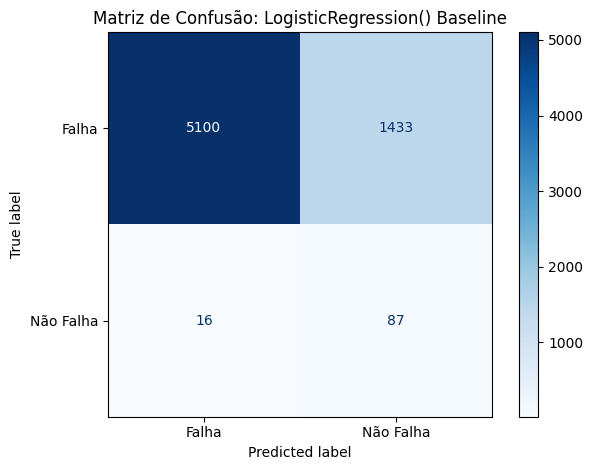

--------------------------------



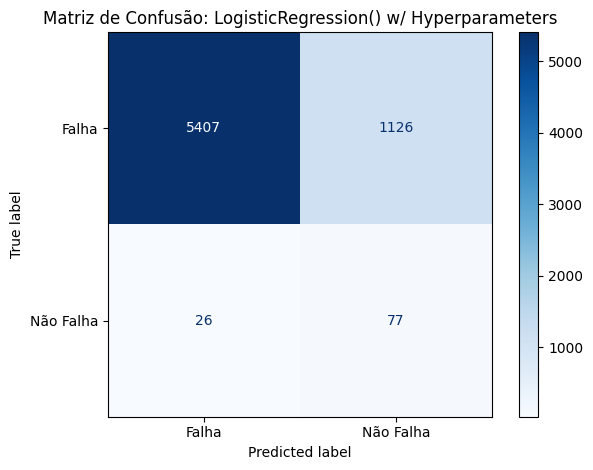

--------------------------------
RandomForestClassifier() Hyperparameters tuned
--------------------------------


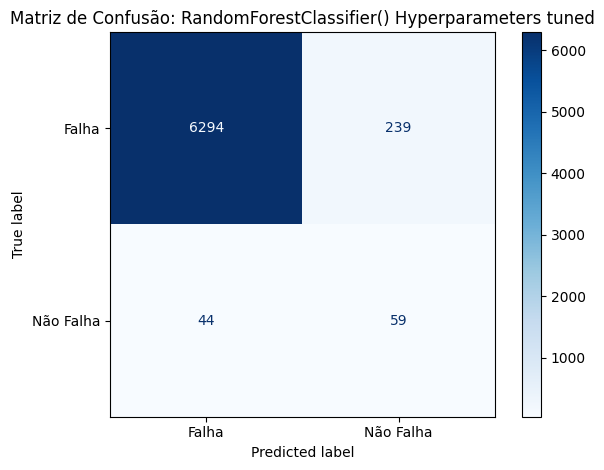

--------------------------------
XGBoost() Hyperparameters tuned
--------------------------------


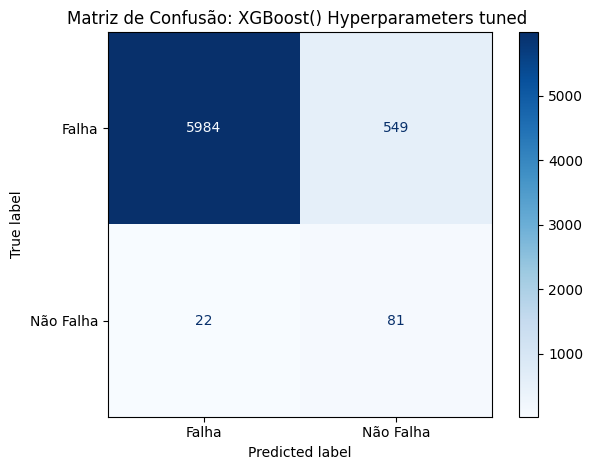

--------------------------------


In [78]:
# Matriz de Confusão
print("Matriz de Confusão")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_lr_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão: LogisticRegression() Baseline")
plt.tight_layout()
plt.show()
print("--------------------------------\n")

cm = confusion_matrix(y_test, y_pred_lr_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão: LogisticRegression() w/ Hyperparameters")
plt.tight_layout()
plt.show()
print("--------------------------------")

print("RandomForestClassifier() Hyperparameters tuned")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_rf_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão: RandomForestClassifier() Hyperparameters tuned")
plt.tight_layout()
plt.show()
print("--------------------------------")


print("XGBoost() Hyperparameters tuned")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_xgb_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão: XGBoost() Hyperparameters tuned ")
plt.tight_layout()
plt.show()
print("--------------------------------")

**Insights:**
 **Melhor Performance Geral: XGBoost**
- Recall (Macro AVG)   ->  85.12% : Detecta bem ambas as classes.
- F1-Score (Macro AVG) ->  58.77% : Melhor equilíbrio geral entre classes.
- Balanced Performance: -> 91.60% : recall na classe majoritária + 78.64% na minoritária
- Menos Overfitting: Não sacrifica totalmente a classe minoritária

Para manutenção preditiva com classes desbalanceadas, o XGBoost oferece:
- Detecção robusta de falhas (91.60% recall classe 0)
- Melhor capacidade de identificar "não-falhas" (78.64% vs 57.28% do RandomForest)
- Performance mais equilibrada entre classes (macro avg superior)
- Menor risco de overfitting à classe majoritária

**Conclusão:**
> O Random Forest, apesar da alta performance geral, sacrifica muito a classe minoritária, o que pode ser problemático em cenários onde identificar corretamente "não-falhas" também é importante para otimização de recursos de manutenção.

## 3. Validação

### XGBoost - Validando com o Melhor Modelo

In [81]:
# --- 0) Parâmetros de execução
TEST_PATH = "../data/raw/bootcamp_test.csv"
OUTPUT_DIR = "../reports/predicoes"
OUTPUT_FILE = "predicoes_bootcamp_test.csv"
THRESHOLD = 0.50           # ajuste se quiser mais/menos sensível a falhas
FAIL_LABEL = 1             # no projeto, 1 = falha (classe minoritária)

# --- 1) Carregar dados de teste
print("Carregando dados de teste externos...")
df_val = pd.read_csv(TEST_PATH)

# --- 2) Preparar features (não remova colunas usadas no treino!)
#     Removemos somente identificadores que não são usados pelo modelo.
drop_cols = ["id", "id_produto"]
X_val = df_val.drop(columns=[c for c in drop_cols if c in df_val.columns], errors="ignore").copy()

print(f"Dimensões de X_val: {X_val.shape}")

# --- 3) Recuperar o melhor pipeline já treinado (pré-processamento + XGB)
#     Preferimos 'best_xgb_pipeline' (boa prática). Em alternativa, use 'xgb_search.best_estimator_'.
try:
    model = best_xgb_pipeline
except NameError:
    try:
        model = xgb_search.best_estimator_
    except NameError:
        raise RuntimeError(
            "Modelo não encontrado. Treine o XGBoost e defina 'best_xgb_pipeline' "
            "ou 'xgb_search' antes de rodar esta validação."
        )

# --- 4) Predições (probabilidade e classe pelo threshold)
#     Descobrimos o índice da coluna de probabilidade correspondente à classe de falha (FAIL_LABEL).
#     Obs.: o Pipeline encaminha o predict_proba ao estimador final.
classes_ = model.named_steps["model"].classes_
fail_idx = int(np.where(classes_ == FAIL_LABEL)[0][0])  # índice da coluna da classe 'falha'

y_proba_fail = model.predict_proba(X_val)[:, fail_idx]
y_pred_fail = (y_proba_fail >= THRESHOLD).astype(int)


# --- 5) Montar resultados
results = pd.DataFrame({
    "id": df_val["id"] if "id" in df_val.columns else np.arange(len(X_val)),
    "falha_maquina": y_pred_fail,          # 0/1 conforme THRESHOLD
    "probabilidade_falha": y_proba_fail    # probabilidade da classe 'falha'
})


# --- 6) Salvar CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
results.to_csv(output_path, index=False)
print(f"Predições salvas em: {output_path}")

# --- 7) Checagens rápidas
print("\nDistribuição das predições (%):")
print((results["falha_maquina"].value_counts(normalize=True) * 100).round(2))

print("\nAmostra das predições:")
print(results.head(10))


Carregando dados de teste externos...
Dimensões de X_val: (7173, 7)
Predições salvas em: ../reports/predicoes\predicoes_bootcamp_test.csv

Distribuição das predições (%):
falha_maquina
0    90.32
1     9.68
Name: proportion, dtype: float64

Amostra das predições:
      id  falha_maquina  probabilidade_falha
0  35260              0             0.359035
1  35261              0             0.192689
2  35262              0             0.027474
3  35263              0             0.031960
4  35264              0             0.022280
5  35265              1             0.724669
6  35266              0             0.143871
7  35267              1             0.709910
8  35268              0             0.019059
9  35269              0             0.021080


## 4. Explicabilidade do Modelo (XAi)
- Usado a biblioteca `explainerdashboard` como ferramenta de explicabilidade do modelo.

In [87]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# garanta índices alinhados (boa prática)
X_test_align = X_test.reset_index(drop=True)
y_test_align = y_test.reset_index(drop=True)

# y deve ser o ground truth, não as predições
explainer = ClassifierExplainer(
    best_xgb_pipeline,
    X_test_align,
    y_test_align,          
    labels=["Não Falha", "Falha"]
)

dashboard = ExplainerDashboard(
    explainer,
    title="Predictive Maintenance: Classifier Explainer XGBoost",
    whatif=False,
    shap_interaction=False,
    decision_trees=False
)

dashboard.run(host='127.0.0.1', 
             port=8050,  
             use_waitress=True) 

dashboard.save_html("../reports/classifier-explainer/XGBoost_BestModel.html")

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calcul

 96%|=================== | 6351/6636 [00:18<00:00]       

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.13:8050


**Conclusão Final com Explicabilidade do Modelo XGBoost**
---
Baseado no relatório gerado acima, foi possível avaliar **Feature Importances (SHAP Values),Precision Plot e Classification Plot** .
- **Pontos Fortes:**
    - Variáveis físicas corretas: Torque e desgaste são realmente críticos para falhas mecânicas
    - Baixos falsos negativos: 0.3% - Essencial para manutenção preditiva
    - Boa calibração: Probabilidades bem distribuídas
    - ROC-AUC elevado: 91% indica excelente capacidade de separação

- **Limitações:**
    - Precision baixa: Impacto do desbalanceamento extremo (1.55% falhas)
    - Conservadorismo: Tende a classificar como falha por segurança

- **Recomendações:**
    - Implementar: Modelo adequado para produção
    - Monitorar: Torque e desgaste como KPIs principais
    - Ajustar Threshold: Considerar cutoff >0.5 para reduzir falsos positivos
    - Coletar dados: Mais amostras da classe minoritária para melhorar precision

> **O modelo oferece segurança operacional priorizando detecção de falhas sobre precisão absoluta, alinhado com os objetivos do projeto de manutenção preditiva**